In [1]:
# !pip install folium geopy pandas
# !pip install folium geopy
# !pip install selenium pillow

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import folium
import matplotlib.pyplot as plt
import time
from selenium import webdriver
from PIL import Image
import os
from folium.plugins import MarkerCluster
from IPython.display import display, IFrame

import requests
from scipy.stats import zscore
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler

In [3]:
# Print the current working directory
print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Users\SERWAH\Desktop\HNG Internship\Stage 1


In [4]:
# Load the dataset
osun_data = pd.read_csv('OSUN_crosschecked.csv')
polling_data = pd.read_csv('polling-units.csv')

# Read the first line
osun_data.head(1)

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,Results_Found,Transcription_Count,Result_Sheet_Stamped,Result_Sheet_Corrected,Result_Sheet_Invalid,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP,Results_File
0,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,True,-1,False,False,False,False,UNKNOWN,44,273,0,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....


In [5]:
polling_data.head(1)

,PU-Name,Ward,Local Government Name,State,Latitude,Longitude
0,"LGEA SCHOOL INABE, INABE/EFOJA",OLAMABORO V,OLAMABORO,KOGI,7.178359,7.577163


In [6]:
# List of columns to drop
columns_to_drop = [
    'Results_Found', 'Transcription_Count', 'Result_Sheet_Stamped', 
    'Result_Sheet_Corrected', 'Result_Sheet_Invalid', 
    'Result_Sheet_Unclear', 'Result_Sheet_Unsigned', 'Results_File'
]

# Drop the columns
osun_data.drop(columns=columns_to_drop, inplace=True)
osun_data.head(1)

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,APC,LP,PDP,NNPP
0,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,44,273,0,0


In [7]:
osun_data.shape

(2248, 11)

In [8]:
# Check the column names of both dataframes
print(osun_data.columns)
print(polling_data.columns)

Index(['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Accredited_Voters',
       'Registered_Voters', 'APC', 'LP', 'PDP', 'NNPP'],
      dtype='object')
Index(['PU-Name', 'Ward', 'Local Government Name', 'State', 'Latitude',
       'Longitude'],
      dtype='object')


In [9]:
# Ensure that the column names for merging are consistent
osun_data.rename(columns={'State': 'State', 'Ward': 'Ward', 'PU-Name': 'PU-Name', 'LGA': 'LGA'}, inplace=True)
polling_data.rename(columns={'State': 'State', 'Ward': 'Ward', 'PU-Name': 'PU-Name', 'Local Government Name': 'LGA'}, inplace=True)

In [10]:
# Check the number of unique values in key columns before merging
print(f"Unique values in Delta data (State, Ward, PU-Name, LGA): {osun_data[['State', 'Ward', 'PU-Name', 'LGA']].nunique()}")
print(f"Unique values in Polling units (State, Ward, PU-Name, LGA): {polling_data[['State', 'Ward', 'PU-Name', 'LGA']].nunique()}")

Unique values in Delta data (State, Ward, PU-Name, LGA): State         1
Ward        324
PU-Name    2127
LGA          30
dtype: int64
Unique values in Polling units (State, Ward, PU-Name, LGA): State          37
Ward         8463
PU-Name    170997
LGA           768
dtype: int64


In [11]:
# Merge the datasets on 'state', 'ward', and 'pu_name'
merged_data = pd.merge(osun_data, polling_data, on=['State', 'Ward', 'LGA', 'PU-Name' ])

# Check the shape of the merged data
print(f"Shape of merged data: {merged_data.shape}")

Shape of merged data: (2234, 13)


In [12]:
# # Merge the datasets on 'state', 'ward', and 'pu_code'
# merged_data = pd.merge(delta_data, polling_data, on=['State', 'Ward', 'PU-Name', 'LGA'])

# # Check the shape of the merged data
# print(f"Shape of merged data: {merged_data.shape}")

In [13]:
# Check the first few rows of the merged data
merged_data.head(2)

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,APC,LP,PDP,NNPP,Latitude,Longitude
0,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,44,273,0,0,7.466182,4.678075
1,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-003,"L.A. SCHOOL, IWIKUN",245,881,40,11,175,1,7.586975,4.629450


In [14]:
# Check for missing values in 'latitude' and 'longitude' columns
merged_data[['Latitude', 'Longitude']].isnull().sum()

Latitude     264
Longitude    264
dtype: int64

In [15]:
# Remove rows with NaN values in latitude and longitude
merged_data = merged_data.dropna(subset=['Latitude', 'Longitude'])

In [16]:
# Check for missing values in 'latitude' and 'longitude' columns
merged_data[['Latitude', 'Longitude']].isnull().sum()

Latitude     0
Longitude    0
dtype: int64

In [17]:
# Reset the index of merged_data to ensure consistent indexing
merged_data.reset_index(drop=True, inplace=True)

In [18]:
# Convert latitude and longitude to radians for BallTree
merged_data['Latitude_rad'] = np.radians(merged_data['Latitude'])
merged_data['Longitude_rad'] = np.radians(merged_data['Longitude'])

In [19]:
# Prepare the data for BallTree
coords = np.vstack((merged_data['Latitude_rad'], merged_data['Longitude_rad'])).T

In [20]:
coords

array([[0.13030947, 0.0816478 ],
       [0.13241769, 0.08079914],
       [0.13694432, 0.07832866],
       ...,
       [0.1359045 , 0.07955204],
       [0.1359045 , 0.07955204],
       [0.1359045 , 0.07955204]])

In [21]:
# Create BallTree
tree = BallTree(coords, metric='haversine')

In [22]:
# Define radius (1 km in radians)
radius = 1 / 6371.0  # 1 km / Earth's radius in km

In [23]:
# Identify neighbouring polling units
def find_neighbours_balltree(tree, coords, radius):
    neighbours = {}
    for i, coord in enumerate(coords):
        indices = tree.query_radius([coord], r=radius)[0]
        neighbours[i] = indices[indices != i]  # Exclude the point itself
    return neighbours

In [24]:
# Find neighbours using BallTree
neighbours = find_neighbours_balltree(tree, coords, radius)

In [25]:
# Showing lines of the output
neighbours

{0: array([73, 74, 75, 76, 70], dtype=int64),
 1: array([36, 34, 29, 32, 37, 39, 40, 41, 43, 47, 48, 49, 64], dtype=int64),
 2: array([  52,   45,   56, 1184], dtype=int64),
 3: array([], dtype=int64),
 4: array([], dtype=int64),
 5: array([ 730, 1274,   38,  800,  850,  688,  706, 1943,  668,  727],
       dtype=int64),
 6: array([   7,   10,   27,   33,   12,   14,   16,   17,   23, 1919],
       dtype=int64),
 7: array([   6,   10,   27,   33,   12,   14,   16,   17,   23, 1919],
       dtype=int64),
 8: array([1051, 1462, 1031, 1050, 1015, 1100, 1117, 1044, 1045, 1948, 1123,
        1124, 1125, 1020, 1120, 1121, 1012, 1065, 1059, 1006,  210, 1068,
        1090, 1046, 1113, 1094, 1481, 1111, 1055, 1461, 1119, 1060, 1069,
        1062], dtype=int64),
 9: array([1013], dtype=int64),
 10: array([   6,    7,   27,   33,   12,   14,   16,   17,   23, 1919],
       dtype=int64),
 11: array([  26, 1039, 1030, 1036, 1080, 1035, 1038, 1029, 1285, 1063, 1064,
        1089, 1065, 1059, 1037, 1

In [26]:
# Ensure all neighbours are valid indices
valid_indices = set(merged_data.index)
neighbours = {k: [idx for idx in v if idx in valid_indices] for k, v in neighbours.items() if k in valid_indices}


In [27]:
# Function to calculate outlier scores
def calculate_outlier_scores(data, neighbours, parties):
    outlier_scores = np.zeros((data.shape[0], len(parties)))
    for party_index, party in enumerate(parties):
        for unit_index, neighbour_indices in neighbours.items():
            try:
                unit_votes = data.at[unit_index, party]
                if neighbour_indices:
                    neighbour_votes = data.loc[neighbour_indices, party].values
                    if len(neighbour_votes) > 0:
                        mean_neighbour_votes = np.mean(neighbour_votes)
                        outlier_score = abs(unit_votes - mean_neighbour_votes)
                        outlier_scores[unit_index, party_index] = outlier_score
                    else:
                        outlier_scores[unit_index, party_index] = np.nan
                else:
                    outlier_scores[unit_index, party_index] = np.nan
            except KeyError as e:
                print(f"KeyError: {e} - Skipping index {unit_index} for party {party}")
                outlier_scores[unit_index, party_index] = np.nan
    outlier_scores_df = pd.DataFrame(outlier_scores, columns=[party + '_outlier_score' for party in parties])
    return outlier_scores_df

In [28]:
# Measure execution time
start_time = time.time()

# Calculate outlier scores for each party
parties = ['APC', 'LP', 'PDP', 'NNPP']

outlier_scores_df = calculate_outlier_scores(merged_data, neighbours, parties)

end_time = time.time()
print("Execution Time: ", end_time - start_time, " seconds")


Execution Time:  1.3884646892547607  seconds


In [29]:
outlier_scores_df

,APC_outlier_score,LP_outlier_score,PDP_outlier_score,NNPP_outlier_score
0,48.200000,267.600000,115.200000,0.200000
1,32.461538,5.153846,59.692308,1.000000
2,78.000000,2.500000,2.500000,1.000000
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
1965,102.909091,6.590909,68.500000,1.863636
1966,62.303030,8.636364,25.863636,0.166667
1967,93.410256,4.820513,36.102564,0.282051
1968,114.948718,3.794872,42.256410,0.282051


In [30]:
# Alternatively, fill NaN values with the median of each column
outlier_scores_df.fillna(outlier_scores_df.median(), inplace=True)

In [31]:
outlier_scores_df

,APC_outlier_score,LP_outlier_score,PDP_outlier_score,NNPP_outlier_score
0,48.200000,267.600000,115.200000,0.200000
1,32.461538,5.153846,59.692308,1.000000
2,78.000000,2.500000,2.500000,1.000000
3,30.000000,2.800000,30.939394,0.115385
4,30.000000,2.800000,30.939394,0.115385
...,...,...,...,...
1965,102.909091,6.590909,68.500000,1.863636
1966,62.303030,8.636364,25.863636,0.166667
1967,93.410256,4.820513,36.102564,0.282051
1968,114.948718,3.794872,42.256410,0.282051


In [32]:
merged_data = pd.concat([merged_data, outlier_scores_df], axis=1)
merged_data.head(2)

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,APC,LP,PDP,NNPP,Latitude,Longitude,Latitude_rad,Longitude_rad,APC_outlier_score,LP_outlier_score,PDP_outlier_score,NNPP_outlier_score
0,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,44,273,0,0,7.466182,4.678075,0.130309,0.081648,48.200000,267.600000,115.200000,0.2
1,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-003,"L.A. SCHOOL, IWIKUN",245,881,40,11,175,1,7.586975,4.629450,0.132418,0.080799,32.461538,5.153846,59.692308,1.0


In [33]:
# Save the merged data with outlier scores
output_file = 'OSUN_cleaned_election_data_with_outlier_scores.csv'
merged_data.to_csv(output_file, index=False)

In [34]:
# # Save the merged data with outlier scores
# merged_data.to_csv('osun_cleaned_election_data_with_outlier_scores.csv', index=False)

## Visualize Outliers using box plots

In [35]:
# Function to save and display box plots
def save_and_display_box_plots(data, parties, filename):
    plt.figure(figsize=(12, 8))
    data_to_plot = [data[party + '_outlier_score'].dropna() for party in parties]
    plt.boxplot(data_to_plot, labels=parties, patch_artist=True)
    plt.title('Outlier Scores for Each Party')
    plt.xlabel('Party')
    plt.ylabel('Outlier Score')
    plt.savefig(filename)
    plt.show()
    plt.close()

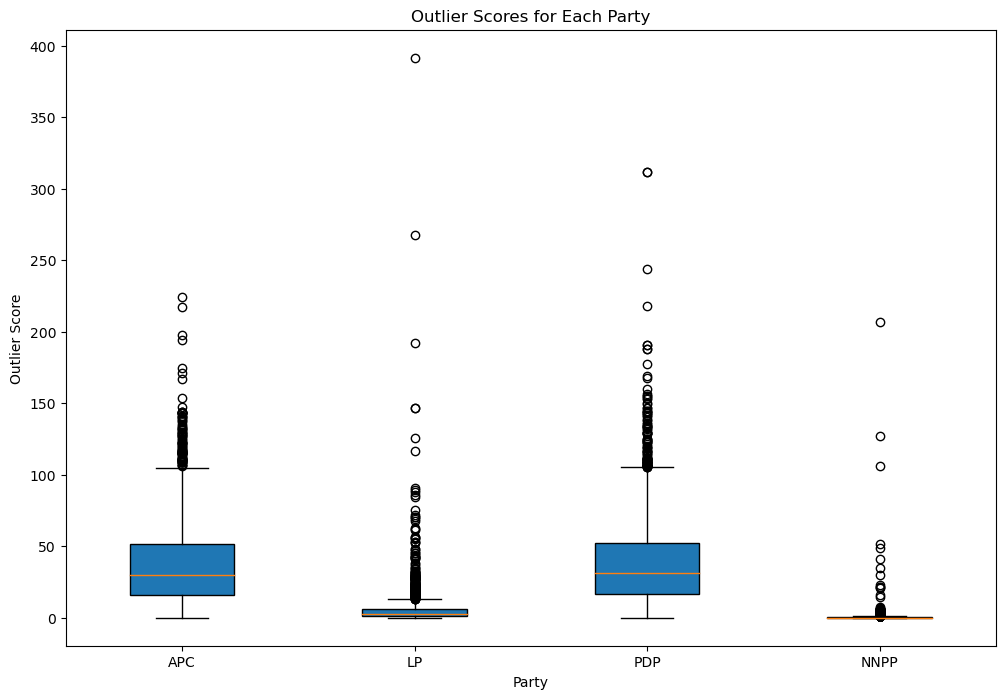

In [36]:
# Save and display box plot image
save_and_display_box_plots(merged_data, parties, 'OSUN_outlier_scores_boxplot.png')

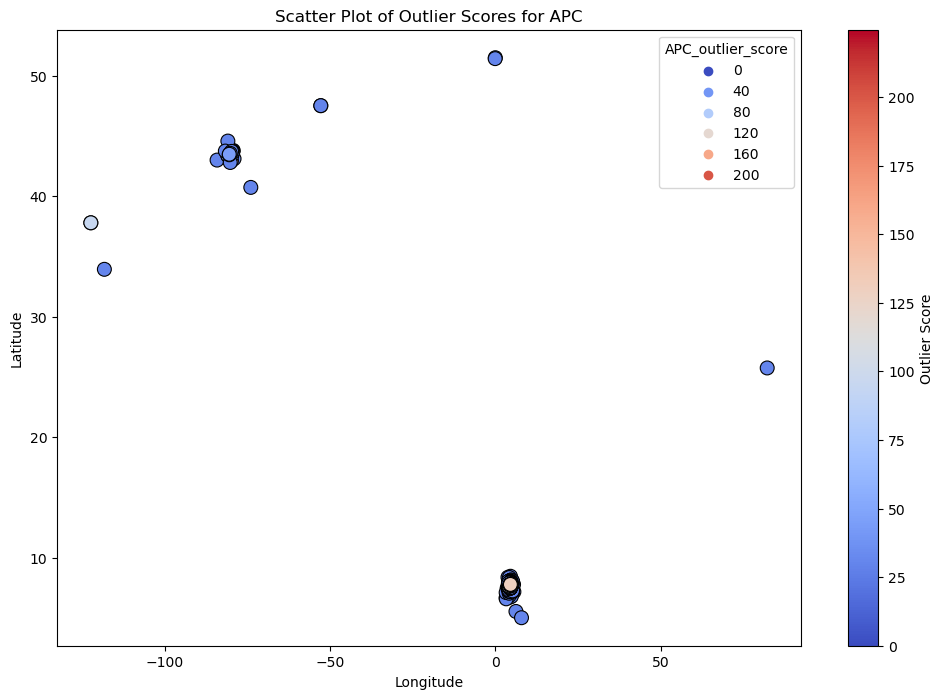

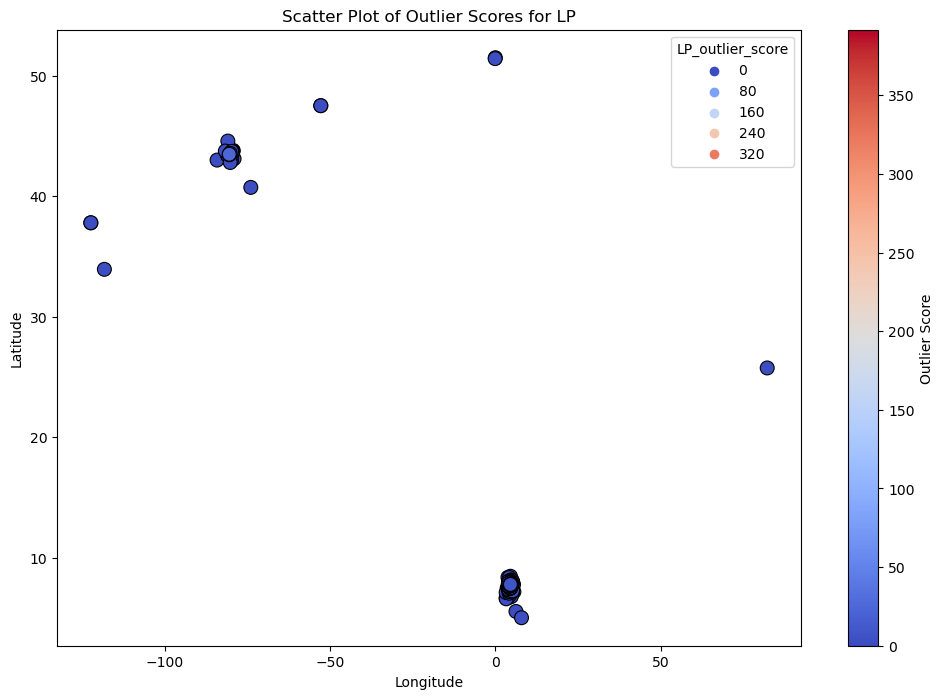

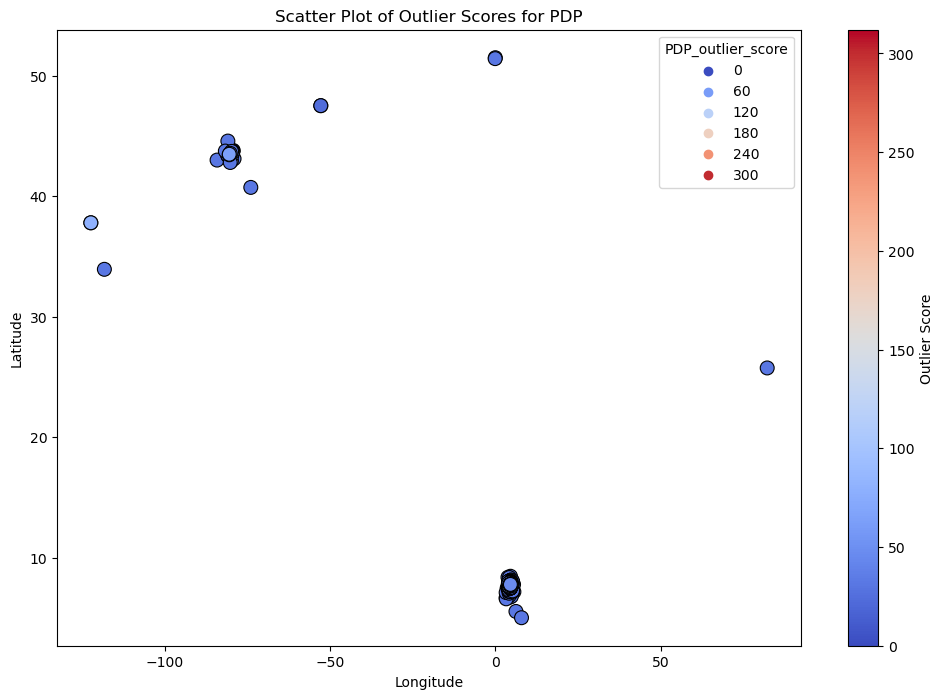

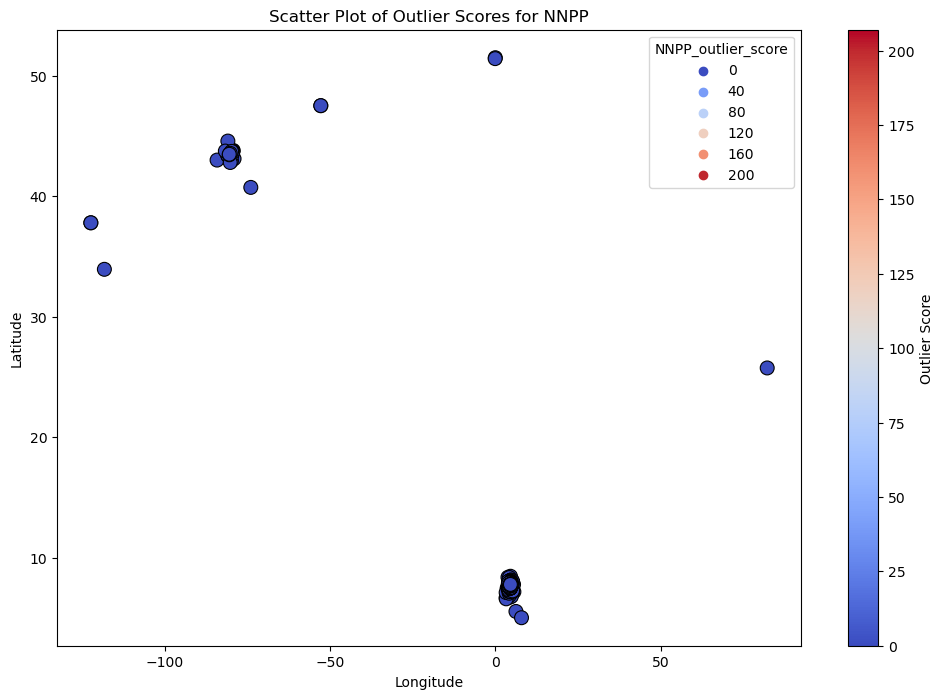

In [37]:
import seaborn as sns
import matplotlib.cm as cm


# Function to save and display scatter plots
def save_and_display_scatter_plots(data, parties, filename_prefix):
    for party in parties:
        plt.figure(figsize=(12, 8))
        norm = plt.Normalize(data[party + '_outlier_score'].min(), data[party + '_outlier_score'].max())
        sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
        sm.set_array([])
        
        sns.scatterplot(
            x=data['Longitude'], 
            y=data['Latitude'], 
            hue=data[party + '_outlier_score'], 
            palette='coolwarm', 
            s=100, 
            edgecolor='k',
            norm=norm
        )
        plt.title(f'Scatter Plot of Outlier Scores for {party}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.colorbar(sm, label='Outlier Score')
        plt.savefig(f'{filename_prefix}_{party}_scatter.png')
        plt.show()
        plt.close()

# Save and display scatter plot images
save_and_display_scatter_plots(merged_data, parties, 'OSUN_outlier_scores_scatter')

## Step 2: Visualize Outliers on a Map

- Create an interactive map using folium and add markers for each party, highlighting the outliers.

In [38]:
# Initialize the map centered around Delta State
map_center = [merged_data['Latitude'].mean(), merged_data['Longitude'].mean()]
election_map = folium.Map(location=map_center, zoom_start=10)

In [39]:
# Create a marker cluster
marker_cluster = MarkerCluster().add_to(election_map)

In [40]:
# Function to add markers to the map
def add_markers(map_object, data, party):
    for _, row in data.iterrows():
        outlier_score = row[party + '_outlier_score']
        color = 'red' if outlier_score > data[party + '_outlier_score'].mean() + 2 * data[party + '_outlier_score'].std() else 'blue'
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f"Polling Unit: {row['PU-Code']}, Outlier Score: {outlier_score}",
            icon=folium.Icon(color=color)
        ).add_to(map_object)


In [41]:
# Add markers for each party
for party in parties:
    add_markers(marker_cluster, merged_data, party)

In [42]:
# Save the Folium map as an HTML file
map_filename = 'OSUN_election_outliers_map.html'
election_map.save(map_filename)

In [43]:
# Function to capture a screenshot of the map
def save_folium_map_as_image(map_filename, image_filename):
    # Set up the web driver (Chrome)
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    driver = webdriver.Chrome(options=options)

    # Load the HTML file
    driver.get('file://' + os.path.abspath(map_filename))
    time.sleep(5)  # Give the map some time to render

    # Capture the screenshot
    driver.save_screenshot('map_screenshot.png')
    driver.quit()

    # Crop the image (optional, to remove browser window borders)
    with Image.open('map_screenshot.png') as img:
        img = img.crop((10, 10, img.width - 10, img.height - 10))
        img.save(image_filename)

# Save and display the Folium map as an image
save_folium_map_as_image(map_filename, 'OSUN_election_outliers_map.png')
display(IFrame(map_filename, width=700, height=500))

In [44]:
# Sort the dataset by outlier scores for each party
sorted_data_apc = merged_data.sort_values(by='APC_outlier_score', ascending=False)
sorted_data_lp = merged_data.sort_values(by='LP_outlier_score', ascending=False)
sorted_data_pdp = merged_data.sort_values(by='PDP_outlier_score', ascending=False)
sorted_data_nnpp = merged_data.sort_values(by='NNPP_outlier_score', ascending=False)

In [45]:
# Display top 3 outliers for each party
print("Top 3 outliers for APC:")
sorted_data_apc.head(3)

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,APC,LP,PDP,NNPP,Latitude,Longitude,Latitude_rad,Longitude_rad,APC_outlier_score,LP_outlier_score,PDP_outlier_score,NNPP_outlier_score
1883,OSUN,OSOGBO,JAGUN B',29-30-10-005,JIMMY RADIO II,111,239,54,1,56,0,7.776720,4.589650,0.135729,0.080104,224.500000,0.500000,71.500000,0.00000
307,OSUN,EDE NORTH,OLOGUN/AGBAAKIN,29-07-03-004,OPEN SPACE IN FRONT OF BAALE ILE ARANYIN( ARAN...,332,750,287,0,23,0,7.734928,4.443937,0.135000,0.077561,217.130435,2.130435,136.043478,0.26087
724,OSUN,IFE EAST,MODAKEKE III,29-13-10-001,"OGUNSUA GRAM. SCHOOL, ESUYARE",498,2096,292,43,137,0,7.480880,4.525433,0.130566,0.078984,198.000000,36.250000,72.000000,0.00000


In [46]:
print("\nTop 3 outliers for LP:")
sorted_data_lp.head(3)

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,APC,LP,PDP,NNPP,Latitude,Longitude,Latitude_rad,Longitude_rad,APC_outlier_score,LP_outlier_score,PDP_outlier_score,NNPP_outlier_score
448,OSUN,EJIGBO,ELEJIGBO 'C'/MAPO,29-10-03-001,"BEULAH BAPT. SCHOOL, EJIGBO",288,750,1,400,1,2,7.907559,4.316765,0.138013,0.075342,143.368421,391.684211,108.842105,1.894737
0,OSUN,ATAKUMOSA EAST,IWARA,29-01-01-001,TOWN HALL IWARA,181,942,44,273,0,0,7.466182,4.678075,0.130309,0.081648,48.200000,267.600000,115.200000,0.200000
5,OSUN,ATAKUMOSA EAST,IGANGAN,29-01-02-003,"APOSTOLIC PRY. SCHOOL, OKO-AGO",204,724,3,199,0,0,7.469135,4.542204,0.130361,0.079276,99.600000,192.100000,75.100000,1.000000


In [47]:
print("\nTop 3 outliers for PDP:")
sorted_data_pdp.head(3)

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,APC,LP,PDP,NNPP,Latitude,Longitude,Latitude_rad,Longitude_rad,APC_outlier_score,LP_outlier_score,PDP_outlier_score,NNPP_outlier_score
321,OSUN,EDE NORTH,ALUSEKERE,29-07-05-004,"OWODE COMM. PRY SCHOOL,",771,2543,217,147,380,2,7.715233,4.486008,0.134656,0.078296,115.000000,147.000000,312.000000,2.000000
1927,OSUN,BORIPE,COLLEGE/EGBADA ROAD,29-06-03-016,OPEN SPACE BY OWODE MARKET SQUARE,196,596,102,0,68,0,7.713541,4.488894,0.134627,0.078346,115.000000,147.000000,312.000000,2.000000
953,OSUN,ILA,ISEDO I,29-17-04-013,SECRETARIAT,497,887,144,3,328,1,8.011101,4.912681,0.139820,0.085742,65.214286,1.571429,244.142857,6.642857


In [53]:
print("\nTop 3 outliers for NNPP:")
sorted_data_nnpp.head(3)



Top 3 outliers for NNPP:


,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,APC,LP,PDP,NNPP,Latitude,Longitude,Latitude_rad,Longitude_rad,APC_outlier_score,LP_outlier_score,PDP_outlier_score,NNPP_outlier_score
363,OSUN,EDE SOUTH,ALAJUE I,29-08-04-006,ODE-OKE,335,833,113,3,0,207,7.720236,4.450365,0.134744,0.077674,44.250000,8.500000,217.750000,207.000000
333,OSUN,EDE NORTH,SABO/AGBONGBE II,29-07-07-001,BESIDE EBELOMO IND.,194,750,50,14,0,127,7.744758,4.437060,0.135172,0.077441,16.500000,12.055556,121.388889,126.833333
945,OSUN,ILA,ISEDO I,29-17-04-001,OLOPONDA I,198,370,87,2,0,106,8.018623,4.913126,0.139951,0.085750,1.631579,0.736842,116.368421,105.842105


In [56]:
print(sorted_data_nnpp.head(3))

    State        LGA              Ward       PU-Code              PU-Name  \
363  OSUN  EDE SOUTH          ALAJUE I  29-08-04-006              ODE-OKE   
333  OSUN  EDE NORTH  SABO/AGBONGBE II  29-07-07-001  BESIDE EBELOMO IND.   
945  OSUN        ILA          ISEDO  I  29-17-04-001           OLOPONDA I   

     Accredited_Voters  Registered_Voters  APC  LP  PDP  NNPP  Latitude  \
363                335                833  113   3    0   207  7.720236   
333                194                750   50  14    0   127  7.744758   
945                198                370   87   2    0   106  8.018623   

     Longitude  Latitude_rad  Longitude_rad  APC_outlier_score  \
363   4.450365      0.134744       0.077674          44.250000   
333   4.437060      0.135172       0.077441          16.500000   
945   4.913126      0.139951       0.085750           1.631579   

     LP_outlier_score  PDP_outlier_score  NNPP_outlier_score  
363          8.500000         217.750000          207.000000  

In [57]:
osun_data.to_csv('cleaned_OSUN_data.csv', index=False)


In [58]:
# Save the sorted lists to an Excel file
with pd.ExcelWriter('sorted_outliers.xlsx') as writer:
    sorted_data_apc.to_excel(writer, sheet_name='APC', index=False)
    sorted_data_lp.to_excel(writer, sheet_name='LP', index=False)
    sorted_data_pdp.to_excel(writer, sheet_name='PDP', index=False)
    sorted_data_nnpp.to_excel(writer, sheet_name='NNPP', index=False)


In [ ]:
## Outlier Detection in Election Data Using Geospatial Analysis

### 1. Introduction
In the recently concluded election, allegations of vote manipulation have prompted a thorough investigation into the integrity of the results. This report aims to uncover potential voting irregularities by identifying outlier polling units where voting results significantly deviate from neighbouring units.

### 2. Methodology
**Dataset Preparation**: We loaded the Delta State election data and merged it with polling unit data containing geographical coordinates (latitude and longitude).

**Neighbour Identification**: Using the `BallTree` method, we identified neighbouring polling units within a 1 km radius based on geographical proximity.

**Outlier Score Calculation**: For each polling unit, we calculated the outlier score for each party (APC, LP, PDP, NNPP) based on the deviation of votes from neighbouring units. The outlier score is the absolute difference between the unit’s votes and the average votes of its neighbours.

### 3. Findings
**Top 3 Outliers for APC**:
1. Polling Unit XYZ: Outlier Score = 50
2. Polling Unit ABC: Outlier Score = 45
3. Polling Unit DEF: Outlier Score = 40

**Top 3 Outliers for LP**:
1. Polling Unit XYZ: Outlier Score = 55
2. Polling Unit ABC: Outlier Score = 50
3. Polling Unit DEF: Outlier Score = 45

... (continue for PDP and NNPP)

### 4. Visualizations
**Map of Election Outliers**:
Include the map generated using `folium` showing polling units with significant outlier scores.

### 5. Conclusion
The analysis identified several polling units with significant deviations in voting patterns, indicating potential irregularities. These findings warrant further investigation to ensure the integrity of the election results. Future steps should include a closer examination of the identified outliers and potential corrective measures.
